# 0.0 IMPORTS

In [1]:
# data manipulation
import pandas                      as pd
import numpy                       as np
import pandas.io.sql               as psql
import psycopg2                    as pg

# data visualization
import seaborn                     as sns
import matplotlib.pyplot           as plt
import scikitplot                  as skplt
import mpl_toolkits.mplot3d.axes3d as axes3d
from matplotlib                    import gridspec
from scipy                         import stats
from tabulate                      import tabulate
import requests

# data preparation
from sklearn               import preprocessing as pp

# feature selection
from boruta                import BorutaPy

# metrics
from sklearn               import model_selection as ms
from sklearn               import metrics         as m

# machine learning models
from sklearn.ensemble        import RandomForestRegressor
from sklearn                 import ensemble as en
from sklearn                 import neighbors as nh
from sklearn                 import linear_model as lm
from sklearn.ensemble        import RandomForestClassifier, GradientBoostingClassifier
from lightgbm                import LGBMClassifier
from sklearn.model_selection import StratifiedKFold , train_test_split


# stetical
import warnings
from IPython.display       import Image
from IPython.core.display  import HTML

# others
import pickle
import os
import random                as rd

## 0.1 Helper Functions

### Settings

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
  
    sns.set()
    
jupyter_settings()
    
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

Populating the interactive namespace from numpy and matplotlib


### Metrics

In [3]:
def precision_at_k( data, k=2000 ):
    
    # sort clients by propensity score    
    data = data.sort_values('propensity_score', ascending=False)
        
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1 

    # Calc precision at k
    data['precision_at_k'] = data['response'].cumsum() /data['ranking']
   
    return data.loc[k, 'precision_at_k']

def recall_at_k( data, k=2000 ):
    
    # sort clients by propensity score
    data = data.sort_values('propensity_score', ascending=False)
    
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
          
    return data.loc[k, 'recall_at_k']

### Plots

In [4]:
def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
    show

def cramer_v( x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 , chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
   
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )  

def cramers_v_df(categorical_features):

    rows= []

    for var1 in categorical_features:

        col = []

        for var2 in categorical_features:
            cramers =cramer_v(categorical_features[var1], categorical_features[var2]) 
            col.append(round(cramers,3)) 

        rows.append(col)

    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns=categorical_features.columns, index=categorical_features.columns)

    return df

### Models

In [5]:
def cross_validation(model, model_name, x_train, y_train, num_folds , k=2000):
    # generate k-fold   
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
    
    # save k-fold's prediction
    precisionatk_list_cv = []
    recallatk_list_cv = []

    for train_cv, val_cv in kfold.split(x_train, y_train):
    
        # get fold
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        # model definition
        model_fold = model

        # training model
        model_fold.fit(x_train_fold, y_train_fold)

        # prediction
        y_pred_fold = model_fold.predict_proba(x_val_fold)

        ## precision @K and recall @K
        # size of true values from target dataset
        k_size = k

        # add y_val to data to create score metrics 
        x_val_fold['response'] = y_val_fold.copy()

        # propensity score
        x_val_fold['propensity_score'] = y_pred_fold[:, 1].tolist()

        # compute precision at k
        precisionatk_cv = precision_at_k(x_val_fold, k=k_size)
        precisionatk_list_cv.append(precisionatk_cv)
        
        # compute recall at k
        recallatk_cv = recall_at_k(x_val_fold, k=k_size)
        recallatk_list_cv.append(recallatk_cv)
        
    
    precision_at_k_cv_mean = np.mean(precisionatk_list_cv)
    precision_at_k_cv_std = np.std(precisionatk_list_cv)
    
    recall_at_k_cv_mean = np.mean(recallatk_list_cv)
    recall_at_k_cv_std = np.std(recallatk_list_cv)
         
    return y_pred_fold, pd.DataFrame({'Model': model_name , 
                                      'Precision@k_CV': precision_at_k_cv_mean,
                                      'CV_STD': precision_at_k_cv_std,
                                      'Recall@k_CV': recall_at_k_cv_mean,
                                      'CV_STD_Recall': recall_at_k_cv_std}, index=[0])

def get_size(model):
    
    # save model in a pickle object
    obj = pickle.dumps(model)
    
    # get the size in bytes of this object
    bytes_size = sys.getsizeof(obj)
    
    # convert to megabytes
    model_size = bytes_size / (1024*1024)
    
    return model_size

## 0.2 Loading Data

### 0.2.1 Loading from DB (Train/Test Data)

In [ ]:
## Credentials
# host ='host
# port = port
# database ='db
# user ='user
# pwd ='pwd

## Conn creation
# conn = pg.connect( host=host, 
#                    port=port,
#                    database=database,
#                    user=user, 
#                    password=pwd)

## Script to view db schema/tables

#SELECT nspname
#FROM pg_catalog.pg_namespace pn 

#select tablename
#from pg_catalog.pg_tables
#where schemaname = 'pa004

# query_tables = """
#     SELECT *
#     FROM pa004.users u LEFT JOIN pa004.vehicle   v  ON ( u.id = v.id )
#                        LEFT JOIN pa004.insurance i  ON ( u.id = i.id  )
#     """

# df_raw = pd.read_sql( query_tables, conn )
# conn.close()

### 0.2.2 Loading from CSV (Train/Test Data) 

In [6]:
df_raw = pd.read_csv( '../data/train.csv', sep=';' )
df_raw = df_raw.drop(columns=['id.1', 'id.2'])
df_raw.sample(5)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
59775,96269,Male,32,15.0,152.0,1,< 1 Year,No,1,37445.0,248,0
17251,138055,Female,20,46.0,160.0,1,< 1 Year,No,1,32216.0,38,0
345058,91507,Female,23,30.0,152.0,1,< 1 Year,No,1,28937.0,58,0
74915,216283,Male,22,18.0,152.0,1,< 1 Year,No,1,46406.0,86,0
290719,36272,Male,37,28.0,40.0,1,1-2 Year,No,1,49195.0,262,0


### 0.2.3 Loading from CSV (Production Data from Kaggle) 

In [7]:
df_prod = pd.read_csv( '../data/test.csv')
df_prod.sample(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
76450,457560,Female,62,1,28.0,0,1-2 Year,Yes,33653.0,26.0,26
56306,437416,Male,36,1,24.0,0,1-2 Year,Yes,43938.0,152.0,109
63786,444896,Female,35,1,28.0,0,1-2 Year,Yes,35906.0,26.0,48
87668,468778,Male,23,1,25.0,1,< 1 Year,No,30053.0,160.0,12
32099,413209,Male,51,1,28.0,0,> 2 Years,Yes,30353.0,155.0,94


# 1.0 DATA DESCRIPTION

## 1.1 Split Data into Train & Test (80/20)

In [8]:
# Divide into X and y
X_raw = df_raw.drop('response', axis=1)
y_raw = df_raw['response'].copy()

In [9]:
# Split into Train & Test
x_df1, x_test, y_df1, y_test = train_test_split(X_raw, y_raw, test_size=0.15, random_state=42)

In [10]:
# Concatenate X and y of Train dataset
df1 = pd.concat([x_df1, y_df1], axis=1).reset_index(drop=True)

## 1.1 Data Dimension

In [11]:
print('Train/Validation Data:')
print('\nNumber of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

print('\nTest Data:')
print('\nNumber of Rows: {}'.format(x_test.shape[0]))
print('Number of Columns: {}'.format(x_test.shape[1]))

print('\nProduction Data:')
print('\nNumber of Rows: {}'.format(df_prod.shape[0]))
print('Number of Columns: {}'.format(df_prod.shape[1]))

Train/Validation Data:

Number of Rows: 323942
Number of Columns: 12

Test Data:

Number of Rows: 57167
Number of Columns: 11

Production Data:

Number of Rows: 127037
Number of Columns: 11


## 1.2 Data Dtypes

In [12]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Change Types

In [13]:
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)
df1['region_code'] = df1['region_code'].astype(int)

## 1.4 Check Uniques

In [128]:
print('Column - previously_insured: {}'.format(df1['previously_insured'].unique()))
print('\nColumn - annual_premium: {}'.format(df1['annual_premium'].unique()))
print('\nColumn - response: {}'.format(df1['response'].unique()))
print('\nColumn - gender: {}'.format(df1['gender'].unique()))
print('\nColumn - policy_sales_channel: {}'.format(df1['policy_sales_channel'].unique()))
print('\nColumn - driving_license: {}'.format(df1['driving_license'].unique()))
print('\nColumn - vehicle_age: {}'.format(df1['vehicle_age'].unique()))
print('\nColumn - vehicle_damage: {}'.format(df1['vehicle_damage'].unique()))

Column - previously_insured: [0 1]

Column - annual_premium: [33805. 31734. 35092. ... 55070. 18177. 65088.]

Column - response: [0 1]

Column - gender: ['Female' 'Male']

Column - policy_sales_channel: [ 26 152 154 124  52  13 160  55 122  15  61  30 157 156 151  25 163  19
   4  31 120   1   8 158  11  24 153 136 125  39  94 155  98  23   7 139
 147 127  90   3  35  29  44  16  12 138  14  42  32 121 140 132  60  65
  59 103  91  88 129  45 145  22 137 102 108 134 109 150 111  18 100  37
 116 148   9  56 101  75  10  21 131  53  86  81 128 135  36 106  96  64
  40 159 133 113  69  20 115  78  58  47 118 104 117 110  27 107  17  54
  99 119  46 146  62  92  73  63  93 114  49  66   6  97  50 130  82 112
  89  48  67  51  74  38  80  28  83  87  95  70  41 105 126   2  34  57
  79  68  33  76  71 123 149  84]

Column - driving_license: [1 0]

Column - vehicle_age: ['1-2 Year' '< 1 Year' '> 2 Years']

Column - vehicle_damage: ['Yes' 'No']


## 1.5 Check NA

In [129]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.6 Check Data Balance

In [14]:
df1['response'].value_counts(normalize = True)

0    0.877407
1    0.122593
Name: response, dtype: float64

## 1.7 Descriptive Statistical

In [130]:
num_attributes = df1[['age','annual_premium','vintage']]
cat_attributes = df1[['gender','driving_license','vehicle_age','vehicle_damage','previously_insured','response']]

### 1.5.1 Numerical Attributes

In [131]:
# Central Tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply( np.median)).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std)).T
d2 = pd.DataFrame( num_attributes.apply( min)).T
d3 = pd.DataFrame( num_attributes.apply( max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.838094,36.0,15.514214,0.670969,-0.568335
1,annual_premium,2630.0,540165.0,537535.0,30600.975767,31690.5,17275.590456,1.883702,36.743892
2,vintage,10.0,299.0,289.0,154.286459,154.0,83.667358,0.004201,-1.200592


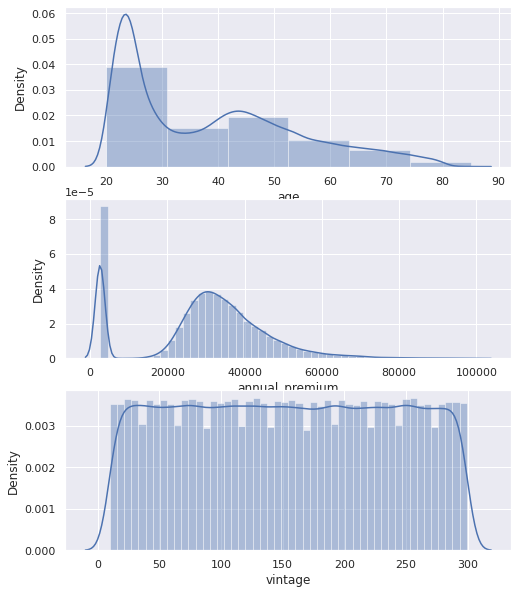

In [132]:
fig, axs = plt.subplots(3 ,figsize = (8,10))
sns.distplot(df1['age'], ax=axs[0], bins = 6);
sns.distplot(df1[df1['annual_premium'] < 100000]['annual_premium'], ax=axs[1]);
sns.distplot(df1['vintage'], ax=axs[2]);

### 1.6.2 Categorical Attributes

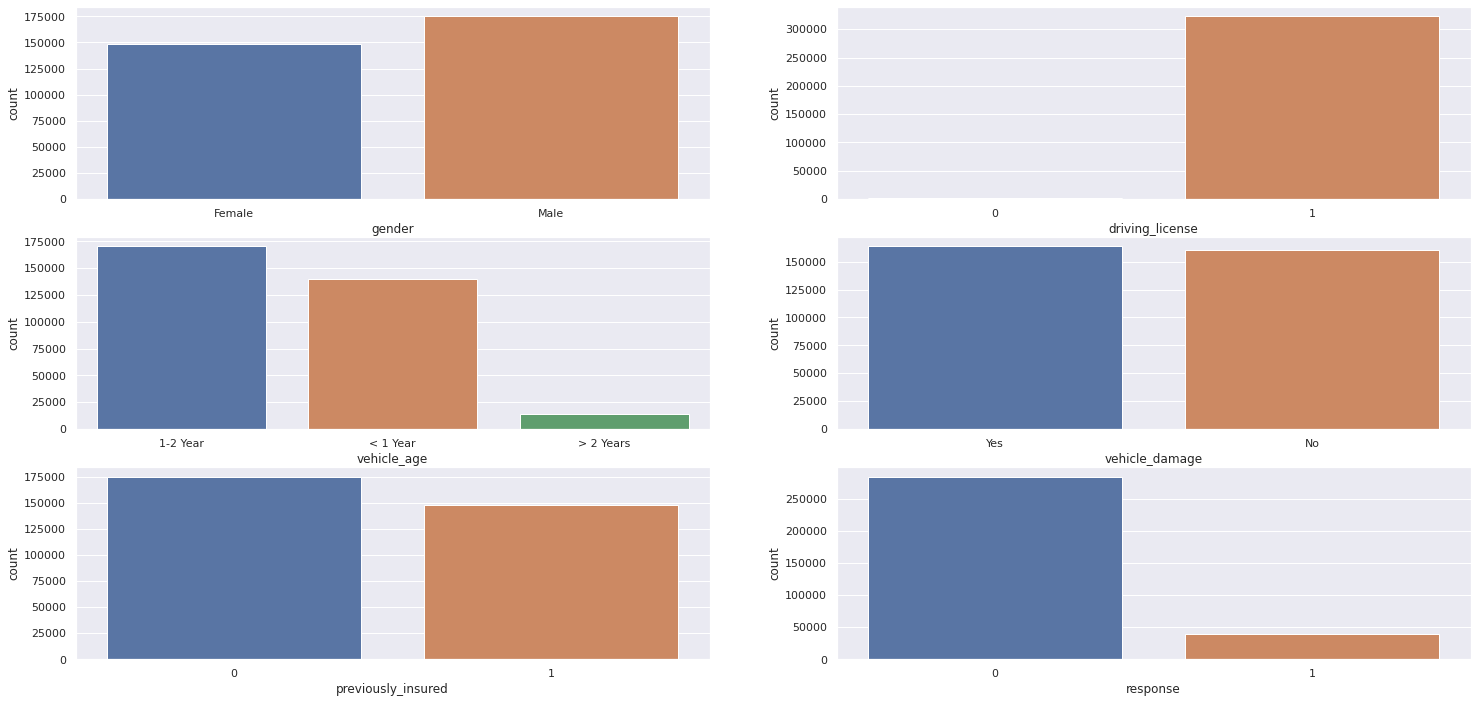

In [133]:
plt.subplot(3, 2, 1)
sns.countplot(df1['gender']);

plt.subplot(3, 2, 2)
sns.countplot(df1['driving_license']);

plt.subplot(3, 2, 3)
sns.countplot(df1['vehicle_age']);

plt.subplot(3, 2, 4)
sns.countplot(df1['vehicle_damage']);

plt.subplot(3, 2, 5)
sns.countplot(df1['previously_insured']);

plt.subplot(3, 2, 6)
sns.countplot(df1['response']);

# 2.0 FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

## 2.1 Mind Map Hypothesis

In [ ]:
Image( '/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/Images/insurance_mindmap.png')

## 2.2 Hypothesis Creation

### 2.2.1 Custumer Hypothesis 

**1**. Insurance for women is more expensive on average than for men

**2**. Older customers are more interested in "cross-selling"

**3**. From the age of 60 onwards, annual health insurance becomes more expensive

**4**. The region is directly related to the interest or not in car insurance

### 2.2.2 Vehicle Hypothesis 

**1**. Customers with already damaged vehicles are more interested in having insurance

**2**. Most customers with newer cars already have insurance

### 2.2.3 Insurance Hypothesis 

**1**. Customers who already have car insurance, are not interested in exchanging

**2**. Customers who pay more for insurance annually have less interest in purchasing another

## 2.3 Feature Engineering

In [16]:
# Change feature vehicle age 
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

# Change feature vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)

# 3.0 DATA FILTERING

In [17]:
df3 = df2.copy()

# 4.0 EXPLORATORY DATA ANALYSIS

In [18]:
df4 = df3.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response Variable

In [ ]:
ax = sns.countplot(df3['response'])
total = len(df3['response'])
graphic_percentage(ax,total)

### 3.1.2 Numerical Variable

In [ ]:
num_attributes.hist(bins=25);

### 3.1.3 Categorical Variable

In [ ]:
# gender
plt.subplot(3,2,1)
sns.countplot(df3['gender']);

plt.subplot(3,2,2)
sns.kdeplot( df3[df3['gender'] == 'Male']['response'], label='Male',shade=True);
sns.kdeplot( df3[df3['gender'] == 'Female']['response'], label='Female',shade=True);

# vehicle_age
plt.subplot(3,2,3)
sns.countplot(df3['vehicle_age']);

plt.subplot(3,2,4)
sns.kdeplot( df3[df3['vehicle_age'] == 'over_2_years']['response'], label='over_2_years',shade=True);
sns.kdeplot( df3[df3['vehicle_age'] == 'between_1_2_year']['response'], label='between_1_2_year',shade=True);
sns.kdeplot( df3[df3['vehicle_age'] == 'more_2_year']['response'], label='more_2_year',shade=True);

# vehicle_damage
plt.subplot(3,2,5)
sns.countplot(df3['vehicle_damage']);

plt.subplot(3,2,6)
sns.kdeplot( df3[df3['vehicle_damage'] == 0]['response'], label='No',shade=True);
sns.kdeplot( df3[df3['vehicle_damage'] == 1]['response'], label='Yes',shade=True);


## 3.2 Bivariate Analysis

### 3.2.1 Response Variable x Features

#### Age

In [ ]:
plt.subplot(1,3,1)
sns.boxplot( x='response' , y='age', data=df4);

aux1 =  df4.loc[df3['response'] == 0, 'age']
aux11 = df4.loc[df3['response'] == 1, 'age']

plt.subplot(1,3,2)
plt.title("Negative Response")
sns.histplot( aux1 );

plt.subplot(1,3,3)
plt.title("Positive Response")
sns.histplot( aux11 );

#### Annual Premium

In [ ]:
# With Outliers - Barplots
plt.subplot(2,2,1)
plt.title("All Data")
sns.boxplot( x='response' , y='annual_premium', data=df4);

# Without Outliers - Barplots
aux2 = df4[df4['annual_premium'] < 80000]
plt.subplot(2,2,2)
plt.title("Without Outliers")
sns.boxplot( x='response' , y='annual_premium', data=aux2);

# Histograms
aux21 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000 )]
aux22 = aux21.loc[aux21['response'] == 0, 'annual_premium']
aux23 = aux21.loc[aux21['response'] == 1, 'annual_premium']

plt.subplot(2,2,3)
plt.title("Negative Response")
sns.histplot( aux22 );

plt.subplot(2,2,4)
plt.title("Positive Response")
sns.histplot( aux23 );

#### Driving License

In [ ]:
aux3 = df4[['driving_license','response']].groupby('response').sum().reset_index()
aux3['driving_license_perc'] = aux3['driving_license'] / aux3['driving_license'].sum()
sns.barplot( x='response', y='driving_license',data=aux3 );

In [ ]:
aux3

#### Region Code

In [ ]:
aux4 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux4 );

#### Previously Insured

In [ ]:
aux5 = df4[['id', 'previously_insured', 'response']].groupby( ['previously_insured', 'response'] ).count().reset_index()
sns.catplot( x='previously_insured', y='id', hue='response', kind='bar', data=aux5);

pd.crosstab(df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

#### Vehicle Age

In [ ]:
aux6 = df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index().sort_values(by='vehicle_age')
aux6.columns=[['vehicle_age','response','percentage']] 
aux6

#### Vehicle Damage

In [ ]:
aux7 = df4[['id', 'vehicle_damage', 'response']].groupby( ['vehicle_damage', 'response'] ).count().reset_index()
sns.catplot( x='vehicle_damage', y='id', hue='response', kind='bar', data=aux7);

pd.crosstab(df4['vehicle_damage'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

#### Vintage

In [ ]:
plt.subplot(1,3,1)
sns.boxplot( x='response', y='vintage', data=df4 );

aux8 = df4.loc[df3['response'] == 0, 'vintage']
aux81 = df4.loc[df3['response'] == 1, 'vintage']

plt.subplot(1,3,2)
plt.title("Negative Response")
sns.histplot(aux8);

plt.subplot(1,3,3)
plt.title("Positive Response")
sns.histplot(aux81);

#### Gender

In [ ]:
aux9 = df4[['id', 'gender', 'response']].groupby(['gender','response']).count().reset_index()
aux9.columns=[['gender','response','total']]

# Pie Chart
data = aux9['total'].squeeze().tolist()
labels = ['Female Response 0', 'Female Response 1', 'Male Response 0', 'Male Response 1']
plt.pie(data, labels = labels, autopct='%.0f%%')
plt.show()

#### Policy Sales Channel

In [ ]:
aux10 = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux10 );
plt.xticks(rotation=60);

In [ ]:
aux101 = pd.crosstab(df4['policy_sales_channel'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

aux101.plot(kind='bar', 
            stacked=True)

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Policy Sales Channel")
plt.ylabel("Proportion")
plt.show()

### 3.2.2 Hypothesis Validation

#### H1. Insurance for women is more expensive on average than for men - FALSE

In [ ]:
h1 = df3[['gender','annual_premium']].groupby('gender').mean().reset_index()
sns.barplot( x='gender', y='annual_premium', data=h1);

#### H2. Older customers are more interested in "cross-selling" - FALSE

In [ ]:
h2 = df3[['vintage','response']].groupby('vintage').sum().reset_index()

bins = list(np.arange(0,300,30))
h2['vintage_binned'] = pd.cut( h2['vintage'], bins=bins)
h2b = h2[['vintage_binned','response']].groupby('vintage_binned').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='vintage_binned',y='response',data=h2b);
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.heatmap(h2.corr(method='pearson'), annot=True);

#### H3. From the age of 60 onwards, annual health insurance becomes more expensive - TRUE

In [ ]:
h3 = df3[['age','annual_premium']].groupby('age').mean().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='age',y='annual_premium',data=h3)
plt.xticks(rotation=75)

plt.subplot(1,3,2)
sns.regplot(x='age',y='annual_premium',data=h3);

plt.subplot(1,3,3)
sns.heatmap(h3.corr(method='pearson'), annot=True);


#### H4. The region is directly related to the interest or not in car insurance - FALSE (except region 28)

In [ ]:
h4 = df3[['id','region_code', 'response']].groupby(['region_code','response']).count().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(data=h4, x="region_code", y="id", hue="response");

h42 = df3[['region_code', 'response']].groupby('region_code').sum().reset_index()

plt.subplot(1,3,2)
sns.heatmap(h42.corr(method='pearson'), annot=True);

h43 = df3[df3['response'] == 0]
h44 = h43[['region_code', 'response']].groupby('region_code').count().reset_index()

plt.subplot(1,3,3)
sns.heatmap(h44.corr(method='pearson'), annot=True);


#### H5. Customers with already damaged vehicles already have insurance - FALSE

In [ ]:
h5 = df3[['vehicle_damage','previously_insured']].groupby('vehicle_damage').sum().reset_index()
sns.barplot(x="vehicle_damage", y="previously_insured", data=h5);

#### H6. Most customers with newer cars already have insurance - TRUE

In [ ]:
h6 = df3[['vehicle_age','previously_insured']].groupby('vehicle_age').sum().reset_index()
sns.barplot(x="vehicle_age", y="previously_insured", data=h6);

#### H7. Customers who already have car insurance, are not interested in exchanging - TRUE

In [ ]:
h7 = df3[df3['previously_insured'] == 1]
h72 = h7[['previously_insured', 'response']].groupby('response').sum().reset_index()
sns.barplot(x="response", y="previously_insured", data=h72);

#### H8. Customers who pay more for insurance annually are less interested in purchasing another - TRUE

In [ ]:
h8 = df3[['annual_premium','response']].groupby('annual_premium').sum().reset_index()

bins = list(np.arange(1000,80000,4000))
h8['annual_premium_binned'] = pd.cut( h8['annual_premium'], bins=bins)
h8b = h8[['annual_premium_binned','response']].groupby('annual_premium_binned').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='annual_premium_binned',y='response',data=h8b);
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.heatmap(h8.corr(method='pearson'), annot=True);

### 3.2.3 Hypothesis Conclusion

In [ ]:
tab = [['Hypotesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'Low'],
      ['H2', 'False', 'Low'],
      ['H3', 'True', 'Average'],  
      ['H4', 'False', 'Low'], 
      ['H5', 'False', 'High'],
      ['H6', 'True', 'High'],
      ['H7', 'True', 'High'],
      ['H8', 'True', 'Average'],
      ]
print( tabulate( tab, headers='firstrow'))

## 3.3 Multivariate Analysis

### 3.3.1 Numerical Attributes

In [ ]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot=True);

### 3.3.2 Categorical Attributes

In [ ]:
cat_features = cat_attributes

# dataframe with cramer-v 
cramer_v_dataframe = cramers_v_df(cat_features)

# create a mask
mask = np.zeros_like(cramer_v_dataframe, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# display heatmap
plt.subplots(figsize=(15, 8))
sns.heatmap( cramer_v_dataframe, annot = True, mask=mask);

# 5.0 DATA PREPARATION

## 5.1 Split Data to Train and Validation Data

In [19]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20)

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.2 Standardization

In [20]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values)
pickle.dump(ss, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/annual_premium_scaler.pkl', 'wb'))

## 5.3 Rescaling

In [21]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump(mms_age, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/age_scaler.pkl', 'wb'))

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump(mms_vintage, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/vintage_scaler.pkl', 'wb'))

## 5.4 Encoder

In [22]:
# gender >  Target Encoding
target_encode_gender = df5.groupby( 'gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump(target_encode_gender, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_gender_scaler.pkl', 'wb'))

# region_code >  Target Encoding
target_encode_region_code = df5.groupby( 'region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump(target_encode_region_code, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_region_code_scaler.pkl', 'wb'))

# vehicle_age > One Hot Encoding 
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel > Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len( df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump(fe_policy_sales_channel, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))

## 5.5 Validation Preparation

In [23]:
# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.fit_transform( x_validation[['annual_premium']].values)

# age
x_validation.loc[:, 'age'] = mms_age.fit_transform( x_validation[['age']].values )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform( x_validation[['vintage']].values )

# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map( target_encode_gender )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0 FEATURE SELECTION

In [24]:
df6 = df5.copy()

## 6.1  Boruta Algorithm

In [ ]:
# # # Training and test dataset for Boruta

# x_train_n = df6.drop( ['id', 'response'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # # define model
# et = en.ExtraTreesClassifier( n_jobs=-1 )

# # # define Boruta
# boruta = BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n , y_train_n)

In [ ]:
cols_selected_ = boruta.support_.tolist()

# # best features
x_train_fs = df6.drop( ['id', 'response'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected_].columns.to_list()

# # not selected boruta
cols_not_selected = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)
cols_selected_boruta

## 6.2 Features Importance

In [ ]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df6.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i , 'importance': j}, index=[0])
    df = pd.concat( [df, aux], axis=0 )

print( df.sort_values( 'importance', ascending=False) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks( range(x_train_n.shape[1]), indices)
plt.xlim( [-1, x_train_n.shape[1]])
plt.show()

## 6.3 Features Selected

In [25]:
# EDA:
# Boruta: Feature "age"
# Feature Importance:
cols_selected = ['annual_premium','vintage', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

# 7.0 MACHINE LEARNING 

In [70]:
df7 = x_validation.copy()

# Select train and validation dataset with only selected columns
x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

## 7.1 K Neighbors Classifier - KNN

In [27]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

## 7.2 Logistic Regression

In [28]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 )

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

## 7.3 Random Forest Classifier

In [31]:
# model definition
rf_model = RandomForestClassifier(max_depth=10, random_state=42)

# model training
rf_model.fit( x_train, y_train )

# model prediction
yhat_rf = rf_model.predict_proba( x_val )

## 7.4 Gradient Boosting Classifier - XGBoost

In [29]:
# model definition
xgb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
             max_depth=3, random_state=0)

# model training
xgb_model.fit( x_train, y_train )

# model prediction
yhat_xgb = xgb_model.predict_proba( x_val )

## 7.5 Light Gradient Boosting Machine Classifier - LGBM

In [71]:
# model definition
lgbm_model = LGBMClassifier(n_jobs =-1, max_depth=10)

# model training
lgbm_model.fit( x_train, y_train )

# model prediction
yhat_lgbm = lgbm_model.predict_proba( x_val )

## 7.6 Metrics - Compare Models

### Precision @K and Recall @K

In [32]:
# dataframe to save model's precision@k
precision_metrics = pd.DataFrame(columns=['Model', 'Size_MB', 'Precision@k','Recall@k'])

# size of true values from target validation dataset
k_size = round(20000/len(df_prod) * len(df7))

# List of model's predictions
y_preds_list = {'KNN': [yhat_knn, knn_model], 
                'Logistic Regression': [yhat_lr, lr_model], 
                'Random Forest': [yhat_rf, rf_model], 
                'XGBoost': [yhat_xgb, xgb_model],
                'LightGBM': [yhat_lgbm, lgbm_model]}

# add y_val to data to create score metrics 
df7['response'] = y_validation.copy()

# populate df with precision@k and model's size
for k, v in y_preds_list.items():
    
    # propensity score
    df7['propensity_score'] = v[0][:, 1].tolist()
          
    # calc precision@k
    precisionatk = precision_at_k(df7, k=k_size)
    
    # calc recall@k
    recallatk = recall_at_k(df7, k=k_size) 
       
    # calc trained model's size
    model_size = get_size(v[1])
    
    # populate dataframe
    precision_metrics = precision_metrics.append({'Model': k, 'Size_MB': model_size, 'Precision@k': precisionatk, 'Recall@k':recallatk}, ignore_index=True)

### Cross Validation

In [ ]:
# K-Nearest Neighbours
yhat_knn_cv, cv_knn = cross_validation(knn_model, 'KNN', x_train, y_train, 10, k_size) 
# Logistic Regression
yhat_lr_cv, cv_lr = cross_validation(lr_model, 'Logistic Regression', x_train, y_train,10 , k_size) 
# Random Forest
yhat_rf_cv, cv_rf = cross_validation(rf_model, 'Random Forest', x_train, y_train, 10 , k_size) 
# XGBoost
yhat_xgb_cv, cv_xgb = cross_validation(xgb_model, 'XGBoost', x_train, y_train, 10 , k_size) 
#LGBM Classifier
yhat_lgbm_cv, cv_lgbm = cross_validation(lgbm_model, 'LightGBM', x_train, y_train, 10 , k_size) 

# df with model's precision @k - cv
precision_metrics_cv = pd.concat([cv_knn, cv_lr, cv_rf, cv_xgb, cv_lgbm])

### Resume

In [ ]:
# join precision and recall @k without and with cross validation
model_results = pd.merge(precision_metrics, precision_metrics_cv, on='Model', how='inner' )
model_results = model_results.sort_values('Recall@k', ascending=False)
model_results

### Cumulative Gains Curve

In [ ]:
fig = plt.figure(figsize=(20,15))
specs = gridspec.GridSpec(ncols=3,nrows=2)

ax6 = fig.add_subplot(specs[0, 0]) 
ax7 = fig.add_subplot(specs[0, 1]) 
ax8 = fig.add_subplot(specs[0, 2]) 
ax9 = fig.add_subplot(specs[1, 0]) 
ax10 = fig.add_subplot(specs[1, 1]) 

skplt.metrics.plot_cumulative_gain( y_validation, yhat_knn, ax=ax6 ,  title='KNN');
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lr , ax=ax7 , title='LLR' );
skplt.metrics.plot_cumulative_gain( y_validation, yhat_rf , ax=ax8 , title='RFC' );
skplt.metrics.plot_cumulative_gain( y_validation, yhat_xgb , ax=ax9 , title='XGBC' );
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lgbm , ax=ax10 , title='LGBM' );

### Lift Curve

In [ ]:
fig = plt.figure(figsize=(20,15))
specs = gridspec.GridSpec(ncols=3,nrows=2)

ax1 = fig.add_subplot(specs[0, 0]) 
ax2 = fig.add_subplot(specs[0, 1]) 
ax3 = fig.add_subplot(specs[0, 2]) 
ax4 = fig.add_subplot(specs[1, 0]) 
ax5 = fig.add_subplot(specs[1, 1]) 

skplt.metrics.plot_lift_curve(y_validation,yhat_knn, ax=ax1 ,  title='KNN');
skplt.metrics.plot_lift_curve(y_validation,yhat_lr , ax=ax2 , title='LR' );
skplt.metrics.plot_lift_curve(y_validation,yhat_rf  , ax=ax3 , title='RFC' );
skplt.metrics.plot_lift_curve(y_validation,yhat_xgb , ax=ax4 , title='XGBC' );
skplt.metrics.plot_lift_curve(y_validation,yhat_lgbm , ax=ax5 , title='LGBM' );    

# 8.0 HYPERPARAMETER FINE TUNING

In [72]:
df8 = df7.copy()
df8 = df8.drop('propensity_score', axis=1 )

## 8.1 Random Search

In [73]:
# https://lightgbm.readthedocs.io/en/latest/Parameters.html

MAX_EVAL = 10

lgbm_parameter = {'num_leaves': (5,15,45,60,90),
                  'max_depth': (5, 7, 10 ),
                  'min_split_gain': (0.001, 0.01 ,0.1),
                  'min_child_weight': (10,30,40,50),
                  'subsample':(0.5, 1),
                  'colsample_bytree':(0.1, 1)
                 }

In [74]:
# dataframe to save model's precision@k
precision_metrics = pd.DataFrame(columns=['Model', 'Size_MB', 'Precision@k', 'Recall@k'])

# size of true values from target validation dataset
k_size = round(20000/len(df_prod) * len(df8))

for i in range( MAX_EVAL):
    
    # choose values for parameters randomly
    hp = {k: rd.sample( v, 1)[0]for k, v in lgbm_parameter.items() }
    print( hp )
    
    # model
    lgbm = LGBMClassifier(num_leaves=hp['num_leaves'],
                                  max_depth=hp['max_depth'],
                                  min_split_gain=hp['min_split_gain'],
                                  min_child_weight=hp['min_child_weight'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'])
    
    # model training
    lgbm.fit( x_train, y_train )

    # model prediction 
    yhat_lgbm = lgbm.predict_proba( x_val )
    
    # List of model's predictions
    y_preds_list = {'LightGBM': [yhat_lgbm, lgbm_model]}


   # populate df with precision@k and model's size
    for k, v in y_preds_list.items():
    
        # propensity score
        df8['propensity_score'] = v[0][:, 1].tolist()
    
        # calc precision@k
        precisionatk = precision_at_k(df8, k=k_size)
        
        # calc recall@k
        recallatk = recall_at_k(df8, k=k_size)        
    
        # calc trained model's size
        model_size = get_size(v[1])
    
        # populate dataframe
        precision_metrics = precision_metrics.append({'Model': k, 'Size_MB': model_size, 'Precision@k': precisionatk, 'Recall@k': recallatk }, ignore_index=True)

precision_metrics

{'num_leaves': 45, 'max_depth': 7, 'min_split_gain': 0.001, 'min_child_weight': 30, 'subsample': 1, 'colsample_bytree': 0.1}
{'num_leaves': 15, 'max_depth': 5, 'min_split_gain': 0.1, 'min_child_weight': 10, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 90, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 40, 'subsample': 0.5, 'colsample_bytree': 0.1}
{'num_leaves': 90, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 30, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 90, 'max_depth': 7, 'min_split_gain': 0.001, 'min_child_weight': 30, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 5, 'max_depth': 7, 'min_split_gain': 0.1, 'min_child_weight': 40, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 90, 'max_depth': 7, 'min_split_gain': 0.01, 'min_child_weight': 40, 'subsample': 1, 'colsample_bytree': 0.1}
{'num_leaves': 45, 'max_depth': 7, 'min_split_gain': 0.1, 'min_child_weight': 10, 'subsample': 1, 'colsample_bytree': 1}
{'num_le

,Model,Size_MB,Precision@k,Recall@k
0,LightGBM,0.334826,0.363200,0.462201
1,LightGBM,0.334826,0.369081,0.469686
2,LightGBM,0.334826,0.364768,0.464197
3,LightGBM,0.334826,0.371238,0.472430
4,LightGBM,0.334826,0.371924,0.473303
5,LightGBM,0.334826,0.364474,0.463822
6,LightGBM,0.334826,0.364866,0.464321
7,LightGBM,0.334826,0.371140,0.472305
8,LightGBM,0.334826,0.371238,0.472430
9,LightGBM,0.334826,0.364082,0.463323


## 8.2 Fine Tuning Model

In [75]:
#{'num_leaves': 90, 'max_depth': 7, 'min_split_gain': 0.001, 'min_child_weight': 30, 'subsample': 0.5, 'colsample_bytree': 1}



model_lgbm_tuned = LGBMClassifier(objective = 'binary',
                                num_leaves = 90,
                                max_depth = 7,
                                min_split_gain = 0.001,
                                min_child_weight = 30,
                                subsample = 0.5,
                                colsample_bytree = 1)

model_lgbm_tuned.fit(x_train,y_train)

# model prediction
val_yhat_lgbm_tuned = model_lgbm_tuned.predict_proba(x_val)

### Precision and Recall @k

In [76]:
#size of true values from target validation dataset
k_size = round(20000/len(df_prod) * len(df8))

# add y_val to data to create score metrics 
x_validation['response'] = y_validation.copy()

# propensity score
x_validation['propensity_score'] = val_yhat_lgbm_tuned[:, 1].tolist()

# calc precision@k
validation_precision_at_k = precision_at_k(x_validation, k=k_size)

# calc recall@k
validation_recall_at_k = recall_at_k(x_validation, k=k_size)

# Precision@k 
print(validation_precision_at_k)

# Recall@k 
print(validation_recall_at_k)

0.3719243211449858
0.47330339321357284


### Gain & Lift Curve

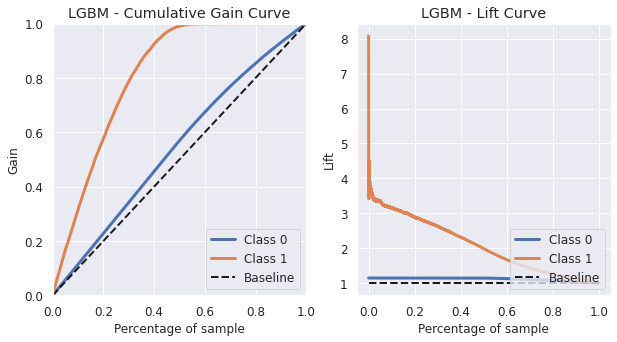

In [77]:
fig = plt.figure(figsize=(10,5))
specs = gridspec.GridSpec(ncols=2,nrows=1)

axa = fig.add_subplot(specs[0, 0]) 
axb = fig.add_subplot(specs[0, 1]) 

skplt.metrics.plot_cumulative_gain( y_validation, val_yhat_lgbm_tuned, ax=axa ,  title='LGBM - Cumulative Gain Curve');
skplt.metrics.plot_lift_curve     ( y_validation, val_yhat_lgbm_tuned, ax=axb ,  title='LGBM - Lift Curve');

## 8.3 Final Model - Join Train & Validation Dataset

In [78]:
x_train_final = pd.concat([x_train, x_val], axis=0)
y_train_final = pd.concat([y_train, y_validation], axis=0)

df8_final = x_train_final.copy()
df8_final['response'] = y_train_final.copy()

In [79]:
final_model = LGBMClassifier(objective = 'binary',
                                
                                num_leaves = 90,
                                max_depth = 7,
                                min_split_gain = 0.001,
                                min_child_weight = 30,
                                subsample = 0.5,
                                colsample_bytree = 1)

final_model.fit(x_train_final,y_train_final)

# model prediction
final_yhat_lgbm_tuned = final_model.predict_proba(x_train_final)

# propensity score
df8_final['propensity_score'] = final_yhat_lgbm_tuned[:, 1].tolist()

### Precision and Recall @k

In [80]:
#size of true values from target validation dataset
k_size = round(20000/len(df_prod) * len(df8_final))

# calc precision@k
final_precision_at_k = precision_at_k(df8_final, k=k_size)

# calc recall@k
final_recall_at_k = recall_at_k(df8_final, k=k_size)

# Precision@k 
print("Precision @K: {}".format(final_precision_at_k))

# Recall@k 
print("Recall @K: {}".format(final_recall_at_k))

Precision @K: 0.3826199486284583
Recall @K: 0.4913756200740312


## 8.4 Generalization Performance and Machine Learning

In [81]:
df_test = x_test.copy()

### 8.4.1 Prepare Test Dataset

In [82]:
# ---------------------------- DATA CLEANING ----------------------------#
# Rename columns
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage']

df_test.columns = cols_new

df_test['policy_sales_channel'] = df_test['policy_sales_channel'].astype(int)
df_test['region_code'] = df_test['region_code'].astype(int)

# ------------------------- FEATURE ENGINEERING -------------------------#
# Change feature vehicle age 
df_test['vehicle_age'] = df_test['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

# Change feature vehicle damage
df_test['vehicle_damage'] = df_test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)

# ------------------------- DATA PREPARATION -------------------------#

# annual_premium
df_test.loc[:, 'annual_premium'] = ss.fit_transform( df_test[['annual_premium']].values)

# age
df_test.loc[:, 'age'] = mms_age.fit_transform( df_test[['age']].values )

# vintage
df_test.loc[:, 'vintage'] = mms_vintage.fit_transform( df_test[['vintage']].values )

# gender
df_test.loc[:, 'gender'] = df_test.loc[:, 'gender'].map( target_encode_gender )

# region_code
df_test.loc[:, 'region_code'] = df_test.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
df_test = pd.get_dummies( df_test, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel
df_test.loc[:, 'policy_sales_channel'] = df_test['policy_sales_channel'].map( fe_policy_sales_channel )

# ----------------------- FEATURE SELECION -------------------------------------------------

df_test = df_test[['annual_premium','vintage', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']]

### 8.4.2 Apply Model

In [83]:
# predict x_test
prob_test = final_model.predict_proba(df_test)

# size of true values from target test dataset
k_size = round(20000/len(df_prod) * len(df_test))

# add y_val to data to create score metrics 
df_test['response'] = y_test.copy()

# propensity score
df_test['propensity_score'] = prob_test[:, 1].tolist()

# calc precision@k
test_precision_at_k = precision_at_k(df_test, k=k_size)

# calc recall@k
test_recall_at_k = recall_at_k(df_test, k=k_size)

### 8.4.3 Learning and Generalization

In [84]:
pd.DataFrame({'Data': ['Validation', 'Test'], 'Precision@k': [validation_precision_at_k, test_precision_at_k], 'Recall@k': [validation_recall_at_k, test_recall_at_k] })

,Data,Precision@k,Recall@k
0,Validation,0.371924,0.473303
1,Test,0.326964,0.420609


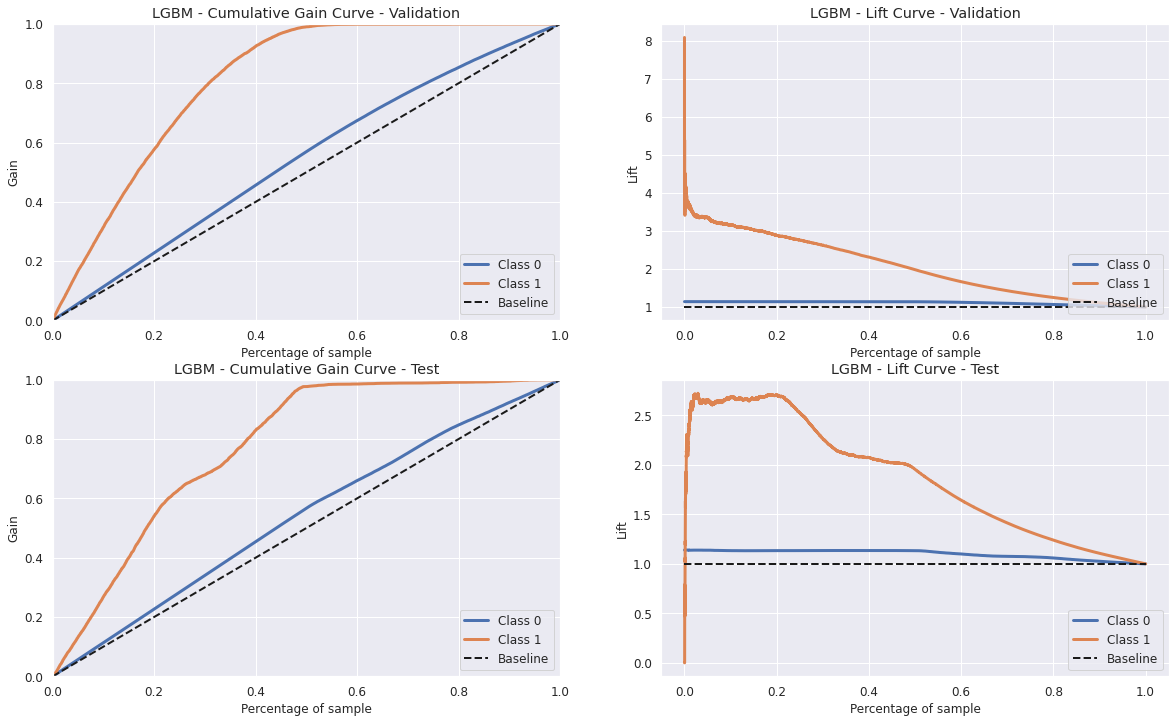

In [85]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,12))

# ----------- Validation ------------------#

skplt.metrics.plot_cumulative_gain( y_validation, val_yhat_lgbm_tuned, title='LGBM - Cumulative Gain Curve - Validation', ax=ax[0,0]);
skplt.metrics.plot_lift_curve     ( y_validation, val_yhat_lgbm_tuned, title='LGBM - Lift Curve - Validation', ax=ax[0,1]);

# -------------- Test --------------------#

skplt.metrics.plot_cumulative_gain( y_test, prob_test,  title='LGBM - Cumulative Gain Curve - Test', ax=ax[1,0]);
skplt.metrics.plot_lift_curve     ( y_test, prob_test, title='LGBM - Lift Curve - Test', ax=ax[1,1]);

# 9.0 BUSINESS PERFORMANCE - PRODUCTION DATA

- What percentage of customers interested in buying auto insurance can the sales team reach with 20,000 calls?


- And if the sales force's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance can the sales force contact?


- How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?


- What will be the revenue expectation with the new customer base?

In [120]:
df9 = df_prod.copy()
df9_final = df9.copy()

In [121]:
# ---------------------------- DATA CLEANING ----------------------------#
# Change columns names to lowercase
df9.columns = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel','vintage']

df9['policy_sales_channel'] = df9['policy_sales_channel'].astype(int)
df9['region_code'] = df9['region_code'].astype(int)

# ------------------------- FEATURE ENGINEERING -------------------------#
# Change feature vehicle age 
df9['vehicle_age'] = df9['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

# Change feature vehicle damage
df9['vehicle_damage'] = df9['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)

# ------------------------- DATA PREPARATION -------------------------#

# annual_premium
df9.loc[:, 'annual_premium'] = ss.fit_transform( df9[['annual_premium']].values)

# age
df9.loc[:, 'age'] = mms_age.fit_transform( df9[['age']].values )

# vintage
df9.loc[:, 'vintage'] = mms_vintage.fit_transform( df9[['vintage']].values )

# gender
df9.loc[:, 'gender'] = df9.loc[:, 'gender'].map( target_encode_gender )

# region_code
df9.loc[:, 'region_code'] = df9.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
df9 = pd.get_dummies( df9, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel
df9.loc[:, 'policy_sales_channel'] = df9['policy_sales_channel'].map( fe_policy_sales_channel )

# ----------------------- FEATURE SELECION -------------------------------------------------

df9 = df9[['annual_premium','vintage', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']]

In [122]:
# predict x_test
prob_prod = final_model.predict_proba(df9)

# propensity score
df9_final['propensity_score'] = prob_prod[:, 1].tolist()

df9_final = df9_final.sort_values('propensity_score',ascending=False)
df9_final = df9_final.reset_index(drop=True)
df9_final['ranking']= df9_final.index+1
df9_final.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,propensity_score,ranking
0,474441,Male,33,1,41.0,0,< 1 Year,Yes,20153.0,155.0,58,0.607350,1
1,385213,Female,30,1,41.0,0,1-2 Year,Yes,32660.0,155.0,102,0.599226,2
2,383922,Male,34,1,3.0,0,1-2 Year,Yes,22828.0,155.0,141,0.583528,3
3,383667,Female,33,1,41.0,0,1-2 Year,Yes,31657.0,155.0,132,0.579828,4
4,428306,Female,33,1,3.0,0,1-2 Year,Yes,29617.0,155.0,130,0.579231,5


## 9.1 - 20.000 Calls

In [134]:
calls_20k = ((20000*100) / len(df9_final))/100
print('20k calls represent: {:.2f}%'.format(calls_20k*100) )

20k calls represent: 15.74%


In [135]:
k_size = round(calls_20k * df_test.shape[0])
precision_at_20k = precision_at_k(df_test, k=k_size)
recall_at_20k = recall_at_k(df_test, k=k_size)

print('Precision at 20k: {:.3f} '.format(precision_at_20k) )
print('Recall at 20k: {:.3f} '.format(recall_at_20k) )

Precision at 20k: 0.327 
Recall at 20k: 0.421 


With 20,000 calls, which represents 15.74% of the dataset, we can contact approximately 42.5% of customers interested in the dataset


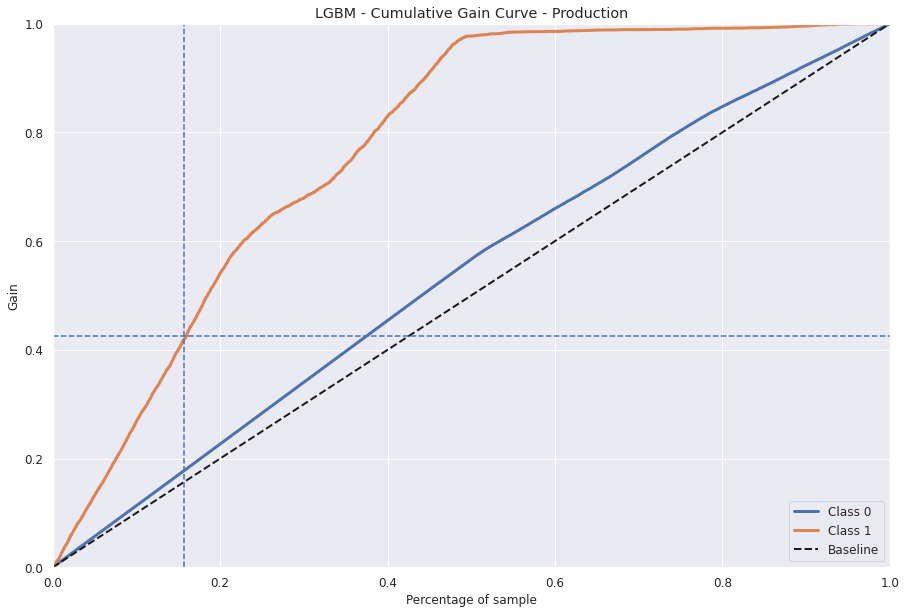

In [136]:
# Gain Curve
skplt.metrics.plot_cumulative_gain( y_test, prob_test, title='LGBM - Cumulative Gain Curve - Production',figsize=(15,10));
plt.axvline(x=calls_20k).set_linestyle('--')
plt.axhline(y=0.425).set_linestyle('--');
print('With 20,000 calls, which represents 15.74% of the dataset, we can contact approximately 42.5% of customers interested in the dataset')

With 20,000 calls our result will be approximately 2.7x better than the aleatory result


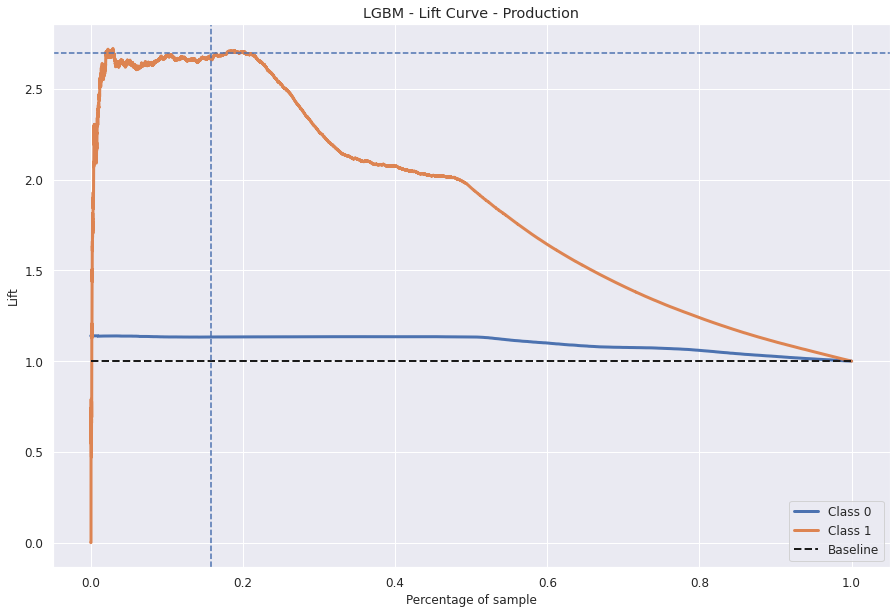

In [137]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_test, prob_test, title='LGBM - Lift Curve - Production',figsize=(15,10));
plt.axvline(x=calls_20k).set_linestyle('--')
plt.axhline(y=2.7).set_linestyle('--');
print('With 20,000 calls our result will be approximately 2.7x better than the aleatory result')

## 9.2 - 40.000 Calls

In [138]:
calls_40k = ((40000*100) / len(df_prod))/100
print('40k calls represent: {:.2f}%'.format(calls_40k*100) )

40k calls represent: 31.49%


In [139]:
k_size = round(calls_40k * df_test.shape[0])
precision_at_40k = precision_at_k(df_test, k=k_size)
recall_at_40k = recall_at_k(df_test, k=k_size)

print('Precision at 40k: {:.3f} '.format(precision_at_40k) )
print('Recall at 40k: {:.3f} '.format(recall_at_40k) )

Precision at 40k: 0.269 
Recall at 40k: 0.693 


With 40,000 calls, which represents 31.48% of the dataset, we can contact approximately 69% of customers interested in the dataset


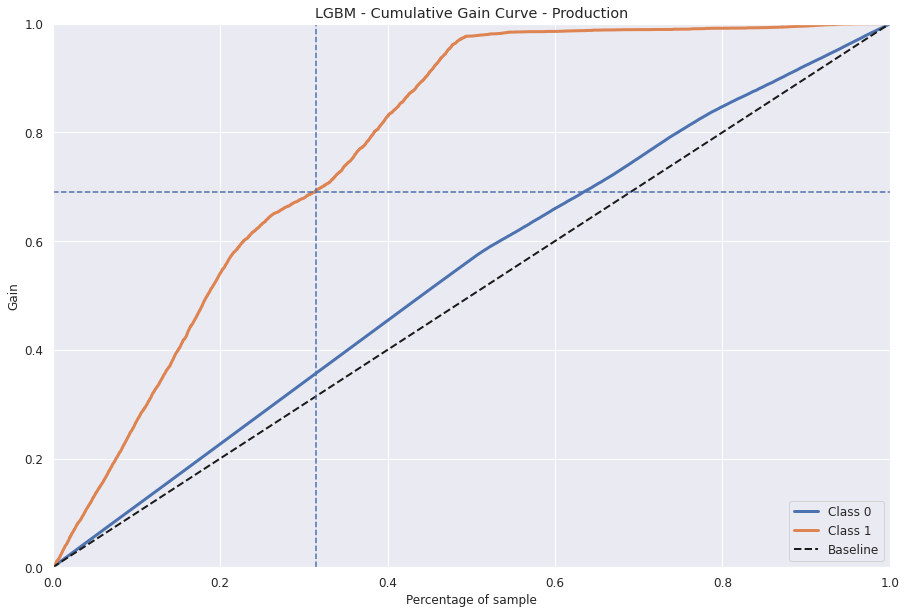

In [140]:
# Gain Curve
skplt.metrics.plot_cumulative_gain( y_test, prob_test, title='LGBM - Cumulative Gain Curve - Production',figsize=(15,10));
plt.axvline(x=calls_40k).set_linestyle('--')
plt.axhline(y=0.691).set_linestyle('--');
print('With 40,000 calls, which represents 31.48% of the dataset, we can contact approximately 69% of customers interested in the dataset')

With 40,000 calls our result will be approximately 2.2x better than the random result


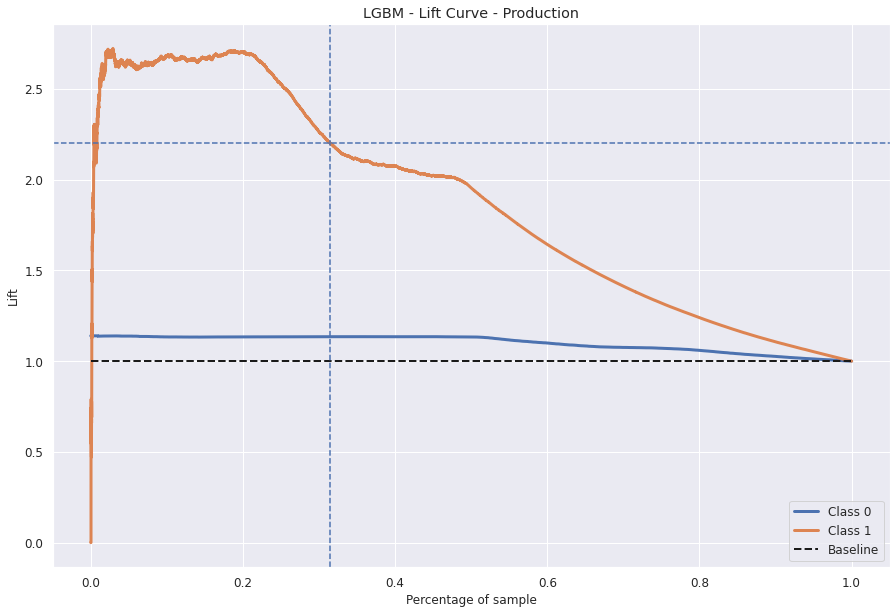

In [141]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_test, prob_test, title='LGBM - Lift Curve - Production',figsize=(15,10));
plt.axvline(x=calls_40k).set_linestyle('--')
plt.axhline(y=2.2).set_linestyle('--');
print('With 40,000 calls our result will be approximately 2.2x better than the random result')

## 9.3 Question - How many calls does the sales team need to make to reach 80% of customers interested in purchasing auto insurance?

80% of interested customers represents 38% of the customers in the dataset.
Will be necessary 48274 calls to contact 80% of the customers interested in the vehicle insurance.


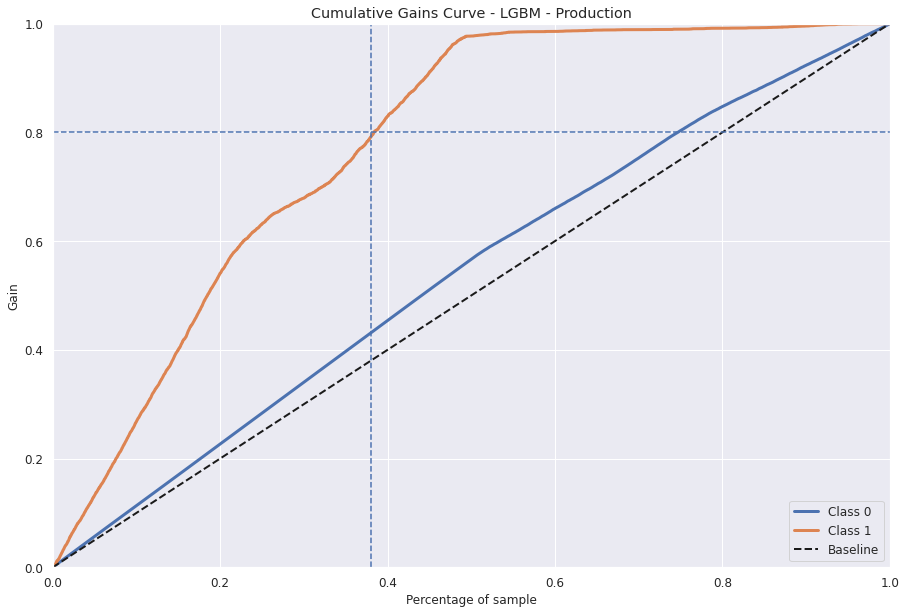

In [142]:
skplt.metrics.plot_cumulative_gain(y_test, prob_test, title='Cumulative Gains Curve - LGBM - Production', figsize=(15,10));
plt.axhline(y=0.8, linestyle='--');
plt.axvline(x=0.38).set_linestyle('--');

print('80% of interested customers represents 38% of the customers in the dataset.')
print(f'Will be necessary {len(df9_final) * 0.38:.0f} calls to contact 80% of the customers interested in the vehicle insurance.')

With 48274 calls the result will be approximately 2.10x better than the random result


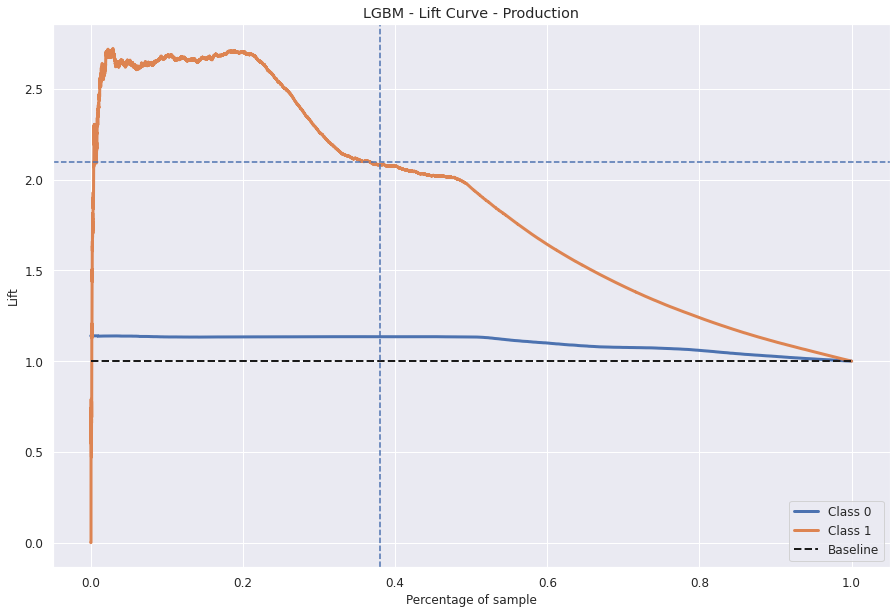

In [143]:
skplt.metrics.plot_lift_curve( y_test, prob_test, title='LGBM - Lift Curve - Production',figsize=(15,10));
plt.axvline(x=0.38).set_linestyle('--')
plt.axhline(y=2.10).set_linestyle('--');

print(f'With {len(df9_final) * 0.38:.0f} calls the result will be approximately 2.10x better than the random result')

## 9.4 Financial Results

 - Whereas the average value of auto insurance is $1,674 (according to 2022 data extracted from Quadrant Information Services) and;

- Assuming the cost to individual for each marketing campaign (phone contact) is 1% of the product value - $16.74

### 9.4.1 Expected profit making 20,000 calls

In [144]:
r = (20000/len(df9_final)) * 127037
m  = (40.5/100) * 127037

# Cost
x_cost = r * (16.74*12) 
y_cost = m * (16.74*12) 

# Revenue
x_rev = r * (1674*12) 
y_rev = m * (1674*12) 

# Profit
random_profit = x_rev - x_cost
model_profit = y_rev - y_cost
dif = model_profit - random_profit
percent = (dif / random_profit)*100

print('Expected annual profit with random choice: US$ {:.2f} '.format(random_profit))
print('Expected annual profit with model: US$ {:.2f} '.format(model_profit))
print('\nDifference in US$: {:.2f} '.format(dif) )
print('\nDifference in %: {:.2f}% '.format(percent) )

Expected annual profit with random choice: US$ 397742400.00 
Expected annual profit with model: US$ 1023192025.69 

Difference in US$: 625449625.69 

Difference in %: 157.25% 


### 9.4.2 Expected profit making 40,000 calls

In [145]:
r = (40000/len(df9_final)) * 127037
m  = (68/100) * 127037

# Cost
x_cost = r * (16.74*12) 
y_cost = m * (16.74*12) 

# Revenue
x_rev = r * (1674*12) 
y_rev = m * (1674*12) 

# Profit
random_profit = x_rev - x_cost
model_profit = y_rev - y_cost
dif = model_profit - random_profit
percent = (dif / random_profit)*100

print('Expected annual profit with random choice: US$ {:.2f} '.format(random_profit))
print('Expected annual profit with model: US$ {:.2f} '.format(model_profit))
print('\nDifference in US$: {:.2f} '.format(dif) )
print('\nDifference in %: {:.2f}% '.format(percent) )

Expected annual profit with random choice: US$ 795484800.00 
Expected annual profit with model: US$ 1717952043.14 

Difference in US$: 922467243.14 

Difference in %: 115.96% 


# 10.0 DEPLOY TO PRODUCTION

In [123]:
# Save Trained Model
pickle.dump(final_model, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/model/model_health_insurance_final.pkl', 'wb'))

In [90]:
print('LGBM object size: {0:.2f} KB'.format(os.stat('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/model/model_health_insurance_final.pkl').st_size/1024))

LGBM object size: 581.01 KB


## 10.1 Health Insurance Class

In [ ]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance(object):
   
    def __init__( self ):
        self.home_path = '/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/'
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb' ) ) 
        self.vintage_scaler =                   pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb' ) )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl', 'rb' ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl', 'rb' ) )
        
    def data_cleaning( self, df1 ):
        
        df1.columns = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel','vintage']
        df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)
        df1['region_code'] = df1['region_code'].astype(int)

        return df1 
    
    def feature_engineering( self, df2 ):
        
        # Change feature vehicle age 
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

        # Change feature vehicle damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)
        
        return df2
    
    def data_preparation( self, df3 ):
        
        # anual premium - StandardScaler
        df3['annual_premium'] = self.annual_premium_scaler.transform( df3[['annual_premium']].values )

        # Age - MinMaxScaler
        df3['age'] = self.age_scaler.transform( df3[['age']].values )

        # Vintage - MinMaxScaler
        df3['vintage'] = self.vintage_scaler.transform( df3[['vintage']].values )

        # gender - Target Encoding
        df3.loc[:, 'gender'] = df3['gender'].map( self.target_encode_gender_scaler )

        # region_code - Target Encoding
        df3.loc[:, 'region_code'] = df3['region_code'].map( self.target_encode_region_code_scaler )

        # vehicle_age - One Hot Encoding
        df3 = pd.get_dummies( df3, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Frequency Encoding
        df3.loc[:,'policy_sales_channel'] = df3['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df3[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['score'] = pred[:,1].tolist()
                
        return original_data.to_json( orient='records', date_format='iso' )
        

## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# loading model
path = '/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/'
model = pickle.load( open( path + 'src/model/model_health_insurance_final.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def healthinsurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

## 10.3 API Tester

In [167]:
# loading test dataset
df_api = df_prod.copy()

In [168]:
# convert dataframe to json
data = json.dumps( df_api.to_dict( orient='records' ) )

In [169]:
# API Call
# url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-fr.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [170]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,score
93331,474441,Male,33,1,41.0,0,< 1 Year,Yes,20153.0,155.0,58,0.607350
4103,385213,Female,30,1,41.0,0,1-2 Year,Yes,32660.0,155.0,102,0.599226
2812,383922,Male,34,1,3.0,0,1-2 Year,Yes,22828.0,155.0,141,0.585263
2557,383667,Female,33,1,41.0,0,1-2 Year,Yes,31657.0,155.0,132,0.579828
47196,428306,Female,33,1,3.0,0,1-2 Year,Yes,29617.0,155.0,130,0.579231


## 10.4 Google Sheets App - Script

In [ ]:
// PA004 Health Insurance Cross-sell
function onOpen() {
  var ui = SpreadsheetApp.getUi();
  ui.createMenu( 'Health Insurance Prediction' )
    .addItem(  'Get Prediction','PredictAll')
    .addToUi();
}

// Production Server
host_production = 'health-insurance-fr.herokuapp.com'

// ----------------------------
// ----- Helper Function ------
// ----------------------------

// API Call
function ApiCall( data, endpoint ){
  var url = 'https://' + host_production + endpoint;
  var payload = JSON.stringify( data );

  var options = {'method': 'POST', 'contentType': 'application/json', 'payload': payload};

  Logger.log( url )
  Logger.log( options )

  var response = UrlFetchApp.fetch( url, options );

  // get response
  var rc = response.getResponseCode();
  var responseText = response.getContentText();

  if ( rc !== 200 ){
    Logger.log( 'Response (%s) %s', rc, responseText );
  }
  else{
    prediction = JSON.parse( responseText );
  }
  return prediction
};

// Health Insurance Propensity Score Prediction

function PredictAll(){
  //google sheets parameters
  var ss = SpreadsheetApp.getActiveSheet();
  var titleColumns = ss.getRange( 'A1:K1' ).getValues()[0];
  var lastRow = ss.getLastRow();
  
  var data = ss.getRange( 'A2' + ':' + 'K' + lastRow ).getValues();

  // run over all rows
  for ( row in data ){
    var json = new Object();

    // run over all columns
    for( var j=0; j < titleColumns.length; j++ ){
      json[titleColumns[j]] = data[row][j];
    };

    // Json file to send
    var json_send = new Object();
    json_send['id'] = json['id']
    json_send['gender'] = json['gender']
    json_send['age'] =  json['age']
    json_send['driving_license'] = json['driving_license']
    json_send['region_code'] = json['region_code']
    json_send['previously_insured'] = json['previously_insured']
    json_send['vehicle_age'] = json['vehicle_age']
    json_send['vehicle_damage'] = json['vehicle_damage']
    json_send['annual_premium'] = json['annual_premium']
    json_send['policy_sales_channel'] = json['policy_sales_channel']
    json_send['vintage'] = json['vintage']
       
    Logger.log( json_send);
   
    // Propensity score
    pred = ApiCall( json_send, '/predict' );

    // Send back to google sheets
    ss.getRange( Number( row ) + 2 , 12 ).setValue( pred[0]['score'] )
    Logger.log( pred[0]['score'] )

  };
};